### Preprocessing of the CAMUS dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import required libraries

In [2]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
from os import path
import numpy as np 
import pandas as pd 
import time
from contextlib import contextmanager # timer
from functools import partial
import seaborn as sns
#To open the .mhd files(MetaImage MetaHeader files)
import SimpleITK as sitk
import matplotlib.pylab as plt
%matplotlib inline
import cv2
from tqdm.notebook import tqdm
#Copy the files to preprocessed folder
import shutil
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 7
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

import h5py


In [5]:
#To get the time taken for processing
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

In [6]:
ROOT_PATH='/content/drive/MyDrive/Medical_Imaging/LVEF/Datasets/CAMUS/Original/database/Preprocessed/'
TRAIN_PATH=ROOT_PATH+'training/'
TEST_PATH=ROOT_PATH+'testing/'

In [7]:
# Z Normalize image by subtracting the mean and dividing by the standrad deviation
def data_norm(input):
    input = np.array(input, dtype=np.float32)
    input  = input - np.mean(input)
    #Add a very small value in denominator to prevent zero division
    output = input / (np.std(input) + 1e-12)
    return output

In [8]:
#Read the .mhd files as array
def mhd_to_array(path):
    """
    Read a *.mhd file stored in path and return it as a numpy array.
    """
    return sitk.GetArrayFromImage(sitk.ReadImage(path, sitk.sitkFloat32))

In [9]:
#Read the .cfg file and return data as a dictionary
def read_info(data_file):
  info = {}
  with open( data_file, 'r' ) as f:
    for line in f.readlines():
      info_type, info_details = line.strip( '\n' ).split( ': ' )
      info[ info_type ] = info_details
  return info


### Visualize a single image and corresponding mask

In [10]:
image = sitk.GetArrayFromImage(sitk.ReadImage(TRAIN_PATH + "4C/frames/patient0044_4CH_ED.mhd", sitk.sitkFloat32))
mask = sitk.GetArrayFromImage(sitk.ReadImage(TRAIN_PATH + "4C/masks/patient0044_4CH_ED_gt.mhd", sitk.sitkFloat32))

In [11]:
np.shape(image)

(1, 1103, 669)

In [12]:
image[0].max()

255.0

In [13]:
np.shape(mask)

(1, 1103, 669)

In [14]:
mask[0].max()

3.0

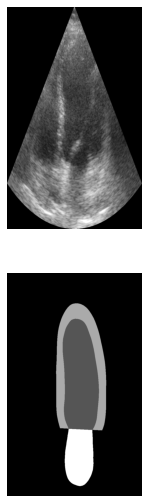

In [15]:
fig, ax = plt.subplots(2)
ax[0].imshow(image[0],cmap='gray') # End Diastolic frame
ax[0].axis('off')
ax[1].imshow(mask[0],cmap='gray') # End Diastolic mask
ax[1].axis('off')
plt.show()

In [16]:
#Get the list of width and heights of all the frames
widths = []
lengths = []
#clst=['2C','4C']
clst=['4C']
for c in clst:
  file_list = os.listdir(os.path.join(TRAIN_PATH, c+"/frames"))
  for i in file_list:
      if "mhd" in i:
        path=TRAIN_PATH+c+"/frames/"+ i
        w = mhd_to_array(path).shape[2]
        l = mhd_to_array(path).shape[1]
        widths.append(w)
        lengths.append(l)
print('Max width : ',max(widths))
print('Min width : ',min(widths))
print('Max length : ',max(lengths))
print('Min length : ',min(lengths))

Max width :  1181
Min width :  323
Max length :  1945
Min length :  584


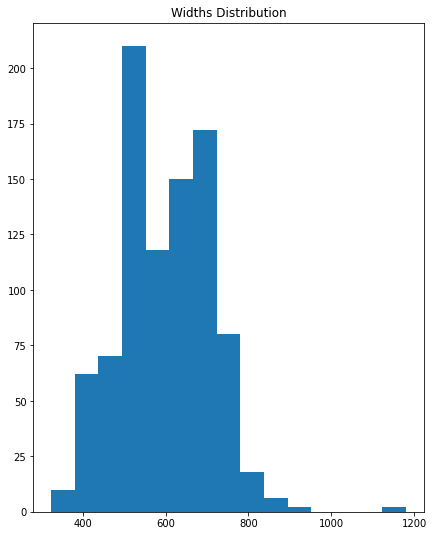

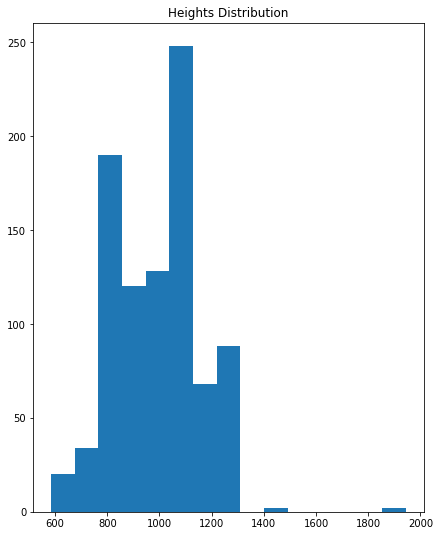

In [17]:
#Plot the width and heights distribution 
widths_array = np.array(widths)
lengths_array = np.array(lengths)

plt.hist(widths_array, bins = 15)
plt.title('Widths Distribution')
plt.show()
plt.hist(lengths_array, bins = 15)
plt.title('Heights Distribution')
plt.show()

In [18]:
#Define the image size
img_size=384

In [19]:
# Define lists storing all images names
#train_2ch_frames_list = sorted(os.listdir(TRAIN_PATH + "2C/frames/"))
#train_2ch_masks_list = sorted(os.listdir(TRAIN_PATH + "2C/masks/"))
# test_2ch_frames_list = sorted(os.listdir(TEST_PATH + "2C/frames/"))
# test_2ch_masks_list = sorted(os.listdir(TEST_PATH + "2C/masks/"))
train_4ch_frames_list = sorted(os.listdir(TRAIN_PATH + "4C/frames/"))
train_4ch_masks_list = sorted(os.listdir(TRAIN_PATH + "4C/masks/"))
test_4ch_frames_list = sorted(os.listdir(TEST_PATH + "4C/frames/"))
test_4ch_masks_list = sorted(os.listdir(TEST_PATH + "4C/masks/"))


In [20]:
# Iterate over images and save rescaled and resized numpy arrays into the corresponding dataset
def saveFramesToDataset(f,framesLst,c,trainortest):
  i=0
  for frame in framesLst:
      if "mhd" in frame:
        path=TRAIN_PATH
        if trainortest=='test':
          path=TEST_PATH
        #Read the .mhd file
        array = mhd_to_array(path+c+"/frames/"+frame)
        #Resize the frames to 384x384 2D array from the 3D array
        new_array = cv2.resize(array[0,:,:], dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
        #Reshape the 2D array to 3D array
        new_array = np.reshape(new_array,(img_size,img_size,1))
        #Standardize the values
        #new_array = data_norm(new_array)
        #Normalize
        new_array = (new_array - new_array.min()) / (new_array.max() - new_array.min())
        #Normalize the values by dividing by 255
        #new_array = new_array/255
        if c=='4C':
          name=trainortest+' 4ch frames'
        elif c=='2C':
          name=trainortest+' 2ch frames'
        f[name][i,...] = new_array[...]
        i+=1

In [21]:
# Iterate over masks and save them as resized numpy arrays into the corresponding dataset
def saveMasksToDataset(f,masksLst,c,trainortest):
  i=0
  for mask in masksLst:
      if "mhd" in mask:
        path=TRAIN_PATH
        if trainortest=='test':
          path=TEST_PATH
        array = mhd_to_array(path+c+"/masks/"+mask)
        new_array = cv2.resize(array[0,:,:], dsize=(img_size, img_size), interpolation=cv2.INTER_NEAREST)
        new_array = np.reshape(new_array,(img_size,img_size,1))
        #new_array = new_array/255.
        if c=='4C':
          name=trainortest+' 4ch masks'
        elif c=='2C':
          name=trainortest+' 2ch masks'
        f[name][i,...] = new_array[...]
        i+=1

In [22]:
# Create hierarchical h5py file, ready to be filled with 4 datasets
f = h5py.File(ROOT_PATH+"image_dataset.hdf5", "w")
#f = h5py.File(ROOT_PATH+"image_dataset.hdf5", "a")

In [23]:
#For U net model your image shapes should be divisible by at least 16 or multiples of 16
#Here we take the image size as 384x384 and 450 ED and 450 ES frames
#HDF5 splits the data into “chunks” of the specified shape, flattens them, and writes them to disk

# f.create_dataset("train 2ch frames", (900, img_size, img_size, 1),
#                 chunks = (4, img_size, img_size, 1), dtype = "float32")

# f.create_dataset("train 2ch masks", (900, img_size, img_size, 1),
#                 chunks = (4, img_size, img_size, 1), dtype = "int32")

# f.create_dataset("test 2ch frames", (100, img_size, img_size, 1),
#                 chunks = (4, img_size, img_size, 1), dtype = "float32")

# f.create_dataset("test 2ch masks", (100, img_size, img_size, 1),
#                 chunks = (4, img_size, img_size, 1), dtype = "int32")

f.create_dataset("train 4ch frames", (900, img_size, img_size,1),
                chunks = (4, img_size, img_size,1), dtype = "float32")

f.create_dataset("train 4ch masks", (900, img_size, img_size,1),
                chunks = (4, img_size, img_size,1), dtype = "int32")

f.create_dataset("test 4ch frames", (100, img_size, img_size,1),
                chunks = (4, img_size, img_size,1), dtype = "float32")

f.create_dataset("test 4ch masks", (100, img_size, img_size,1),
                chunks = (4, img_size, img_size,1), dtype = "int32")



<HDF5 dataset "test 4ch masks": shape (100, 384, 384, 1), type "<i4">

In [24]:
#Load the frames numpy arrays after resizing and normalizing to the dataset
#saveFramesToDataset(f,train_2ch_frames_list,'2C','train')
#saveMasksToDataset(f,train_2ch_masks_list,'2C','train')
#saveFramesToDataset(f,test_2ch_frames_list,'2C','test')
#saveMasksToDataset(f,test_2ch_masks_list,'2C','test')

saveFramesToDataset(f,train_4ch_frames_list,'4C','train')
saveMasksToDataset(f,train_4ch_masks_list,'4C','train')
saveFramesToDataset(f,test_4ch_frames_list,'4C','test')
saveMasksToDataset(f,test_4ch_masks_list,'4C','test')

f.close()

(900, 384, 384, 1)


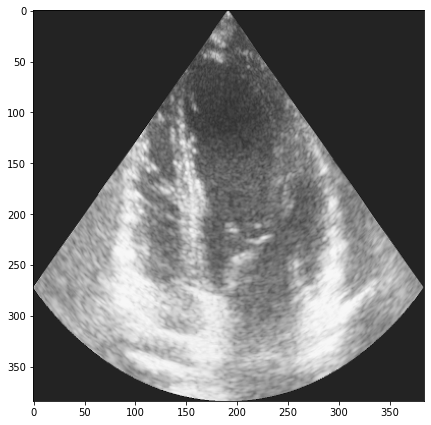

(900, 384, 384, 1)


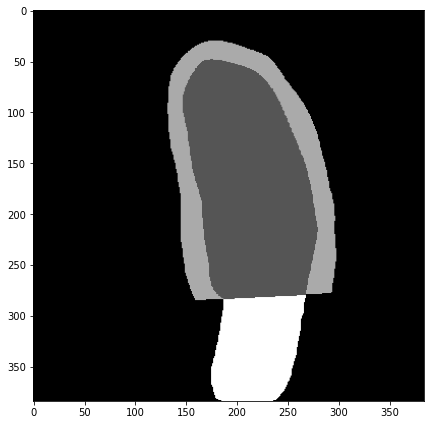

In [27]:
#Read and visualize image and mask from the train file
f = h5py.File(ROOT_PATH+"image_dataset.hdf5", "r")
train_frames = f["train 4ch frames"]
print(train_frames.shape)
plt.imshow(train_frames[0,:,:,0],cmap='gray')
plt.show()
train_masks = f["train 4ch masks"]
print(train_masks.shape)
plt.imshow(train_masks[0,:,:,0],cmap='gray')
plt.show()

(100, 384, 384, 1)


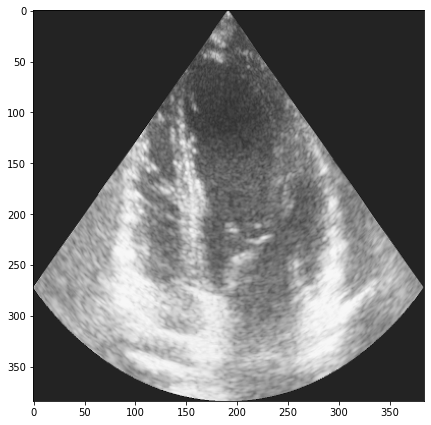

(100, 384, 384, 1)


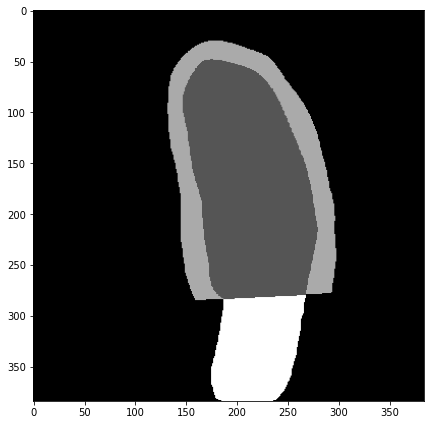

In [28]:
#Read and visualize image and mask from the test file
f = h5py.File(ROOT_PATH+"image_dataset.hdf5", "r")
test_frames = f["test 4ch frames"]
print(test_frames.shape)
plt.imshow(test_frames[0,:,:,0],cmap='gray')
plt.show()
test_masks = f["test 4ch masks"]
print(test_masks.shape)
plt.imshow(test_masks[0,:,:,0],cmap='gray')
plt.show()